This notebook explore the potential of using ML classification techniques to categorize and predict the productivity of garment workers. 
Data set available at https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
parent = os.path.abspath(os.path.join(cwd,'..'))
print(parent)
plt.style.use(parent+'/plot_style_mk.mplstyle')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = ['navy','brown','royalblue'])

/Users/meghanadkayanattil/Documents/GitHub/Data_Science_Python_notebooks


In [5]:
#loading the data set
data_file = parent+'/Data_files/garments_worker_productivity.csv'
data_raw = pd.read_csv(data_file)
data_raw.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [6]:
#information about the data set
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [7]:
# Checking if there are any rows with missing information
data_raw.isnull().values.any()

True

In [8]:
m, n = data_raw.shape
# Percentage of empty cells for each column.
(data_raw.isnull().sum()/m)*100

date                      0.000000
quarter                   0.000000
department                0.000000
day                       0.000000
team                      0.000000
targeted_productivity     0.000000
smv                       0.000000
wip                      42.272348
over_time                 0.000000
incentive                 0.000000
idle_time                 0.000000
idle_men                  0.000000
no_of_style_change        0.000000
no_of_workers             0.000000
actual_productivity       0.000000
dtype: float64

In [9]:
# since only the work in progress column is having null values, I will initiall-
#-y try to do the analysis after removing the wip row
data_raw = data_raw.drop('wip', axis=1)
data_raw.head()

,date,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382


In [10]:
# We have no null objects now, so we check for duplicates
print(f'With duplicates = {data_raw.shape}')
print(data_raw.duplicated().any())
data_clean = data_raw.drop_duplicates()
print(f'With out duplicates = {data_clean.shape}')

With duplicates = (1197, 14)
False
With out duplicates = (1197, 14)


We also have no duplicates, time to see the where we need to change categorical variable to dummy numerical ones.

There are quarter, department and day which are categorical features here.
Among this, all cn be treated as nominal, I do not believe that there is a need to treat different days with different priorities

The team number also need to be considered as a categorical feature

In [11]:
print(data_clean['quarter'].value_counts())
print('---------------------------------')
print(data_clean['department'].value_counts())
print('---------------------------------')
print(data_clean['day'].value_counts())
print('---------------------------------')
print(data_clean['team'].value_counts())

Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64
---------------------------------
sweing        691
finishing     257
finishing     249
Name: department, dtype: int64
---------------------------------
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: day, dtype: int64
---------------------------------
8     109
2     109
1     105
4     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: team, dtype: int64


In [12]:
# The department column has a weired feature, I believe thus, I am changing
# the data type from object ot string and performin the unique value
# operation again
print(data_clean['department'].value_counts().index)
# As I suspected there is a white space creating problems for me 
data_clean['department'] = data_clean['department'].str.replace('finishing ', 'finishing', regex=False)
print(data_clean['department'].value_counts()) # After fixing a silly error in 
# data set

Index(['sweing', 'finishing ', 'finishing'], dtype='object')
sweing       691
finishing    506
Name: department, dtype: int64


In [13]:
data_final = pd.get_dummies(data_clean, columns = ['department', 'day'])
data_final.head()

,date,quarter,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,department_finishing,department_sweing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,1/1/2015,Quarter1,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,0,1,0,0,0,1,0,0
1,1/1/2015,Quarter1,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,1,0,0,0,0,1,0,0
2,1/1/2015,Quarter1,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,0,1,0,0,0,1,0,0
3,1/1/2015,Quarter1,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,0,1,0,0,0,1,0,0
4,1/1/2015,Quarter1,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,0,1,0,0,0,1,0,0


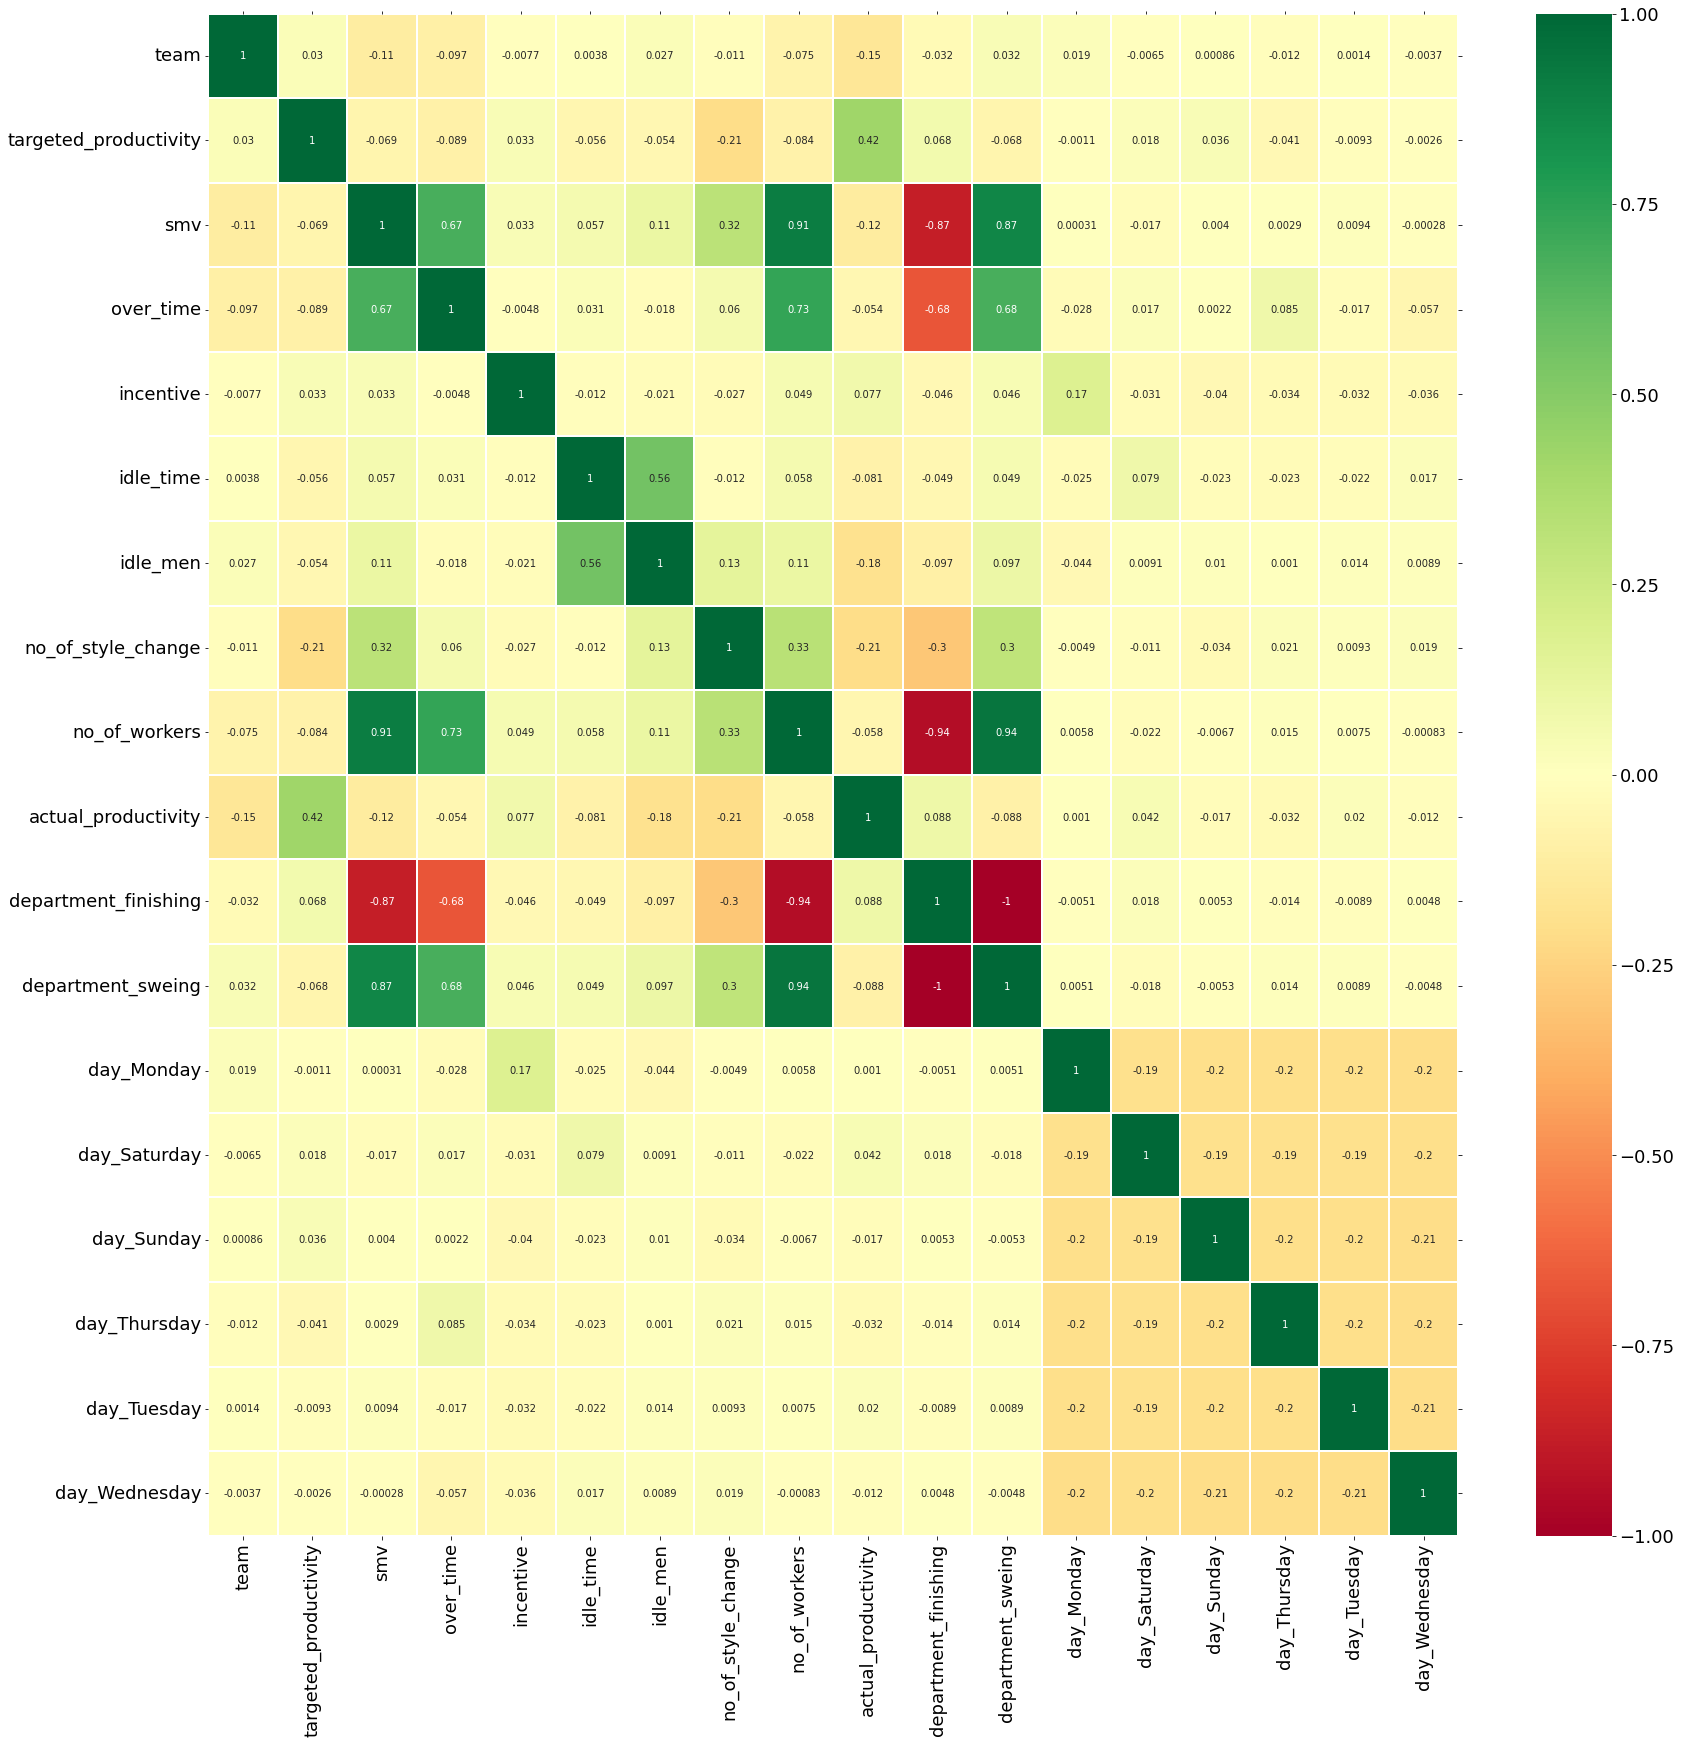

In [15]:
plt.figure(figsize=(28, 28))
#matrix = np.triu(data_final.corr())
sns.heatmap(data_final.corr(), annot=True,
            linewidth=.2,  cmap="RdYlGn")
plt.show();

Weekdays seems to have no positive or negative correlation thus not necessary for prediction. For now we can remove that feature. Will be added later if needed

In [16]:
data_clean = data_clean.drop('day', axis =1)
data_clean.head()

,date,quarter,department,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382


In [17]:
data_final = pd.get_dummies(data_clean, columns = ['department', 'team']).drop(['quarter', 'date'], axis =1)
data_final.head()

,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,department_finishing,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,0,...,0,0,0,0,0,1,0,0,0,0
1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,1,...,0,0,0,0,0,0,0,0,0,0
2,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,0,...,0,0,0,0,0,0,0,0,1,0
3,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,0,...,0,0,0,0,0,0,0,0,0,1
4,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,0,...,0,0,0,1,0,0,0,0,0,0


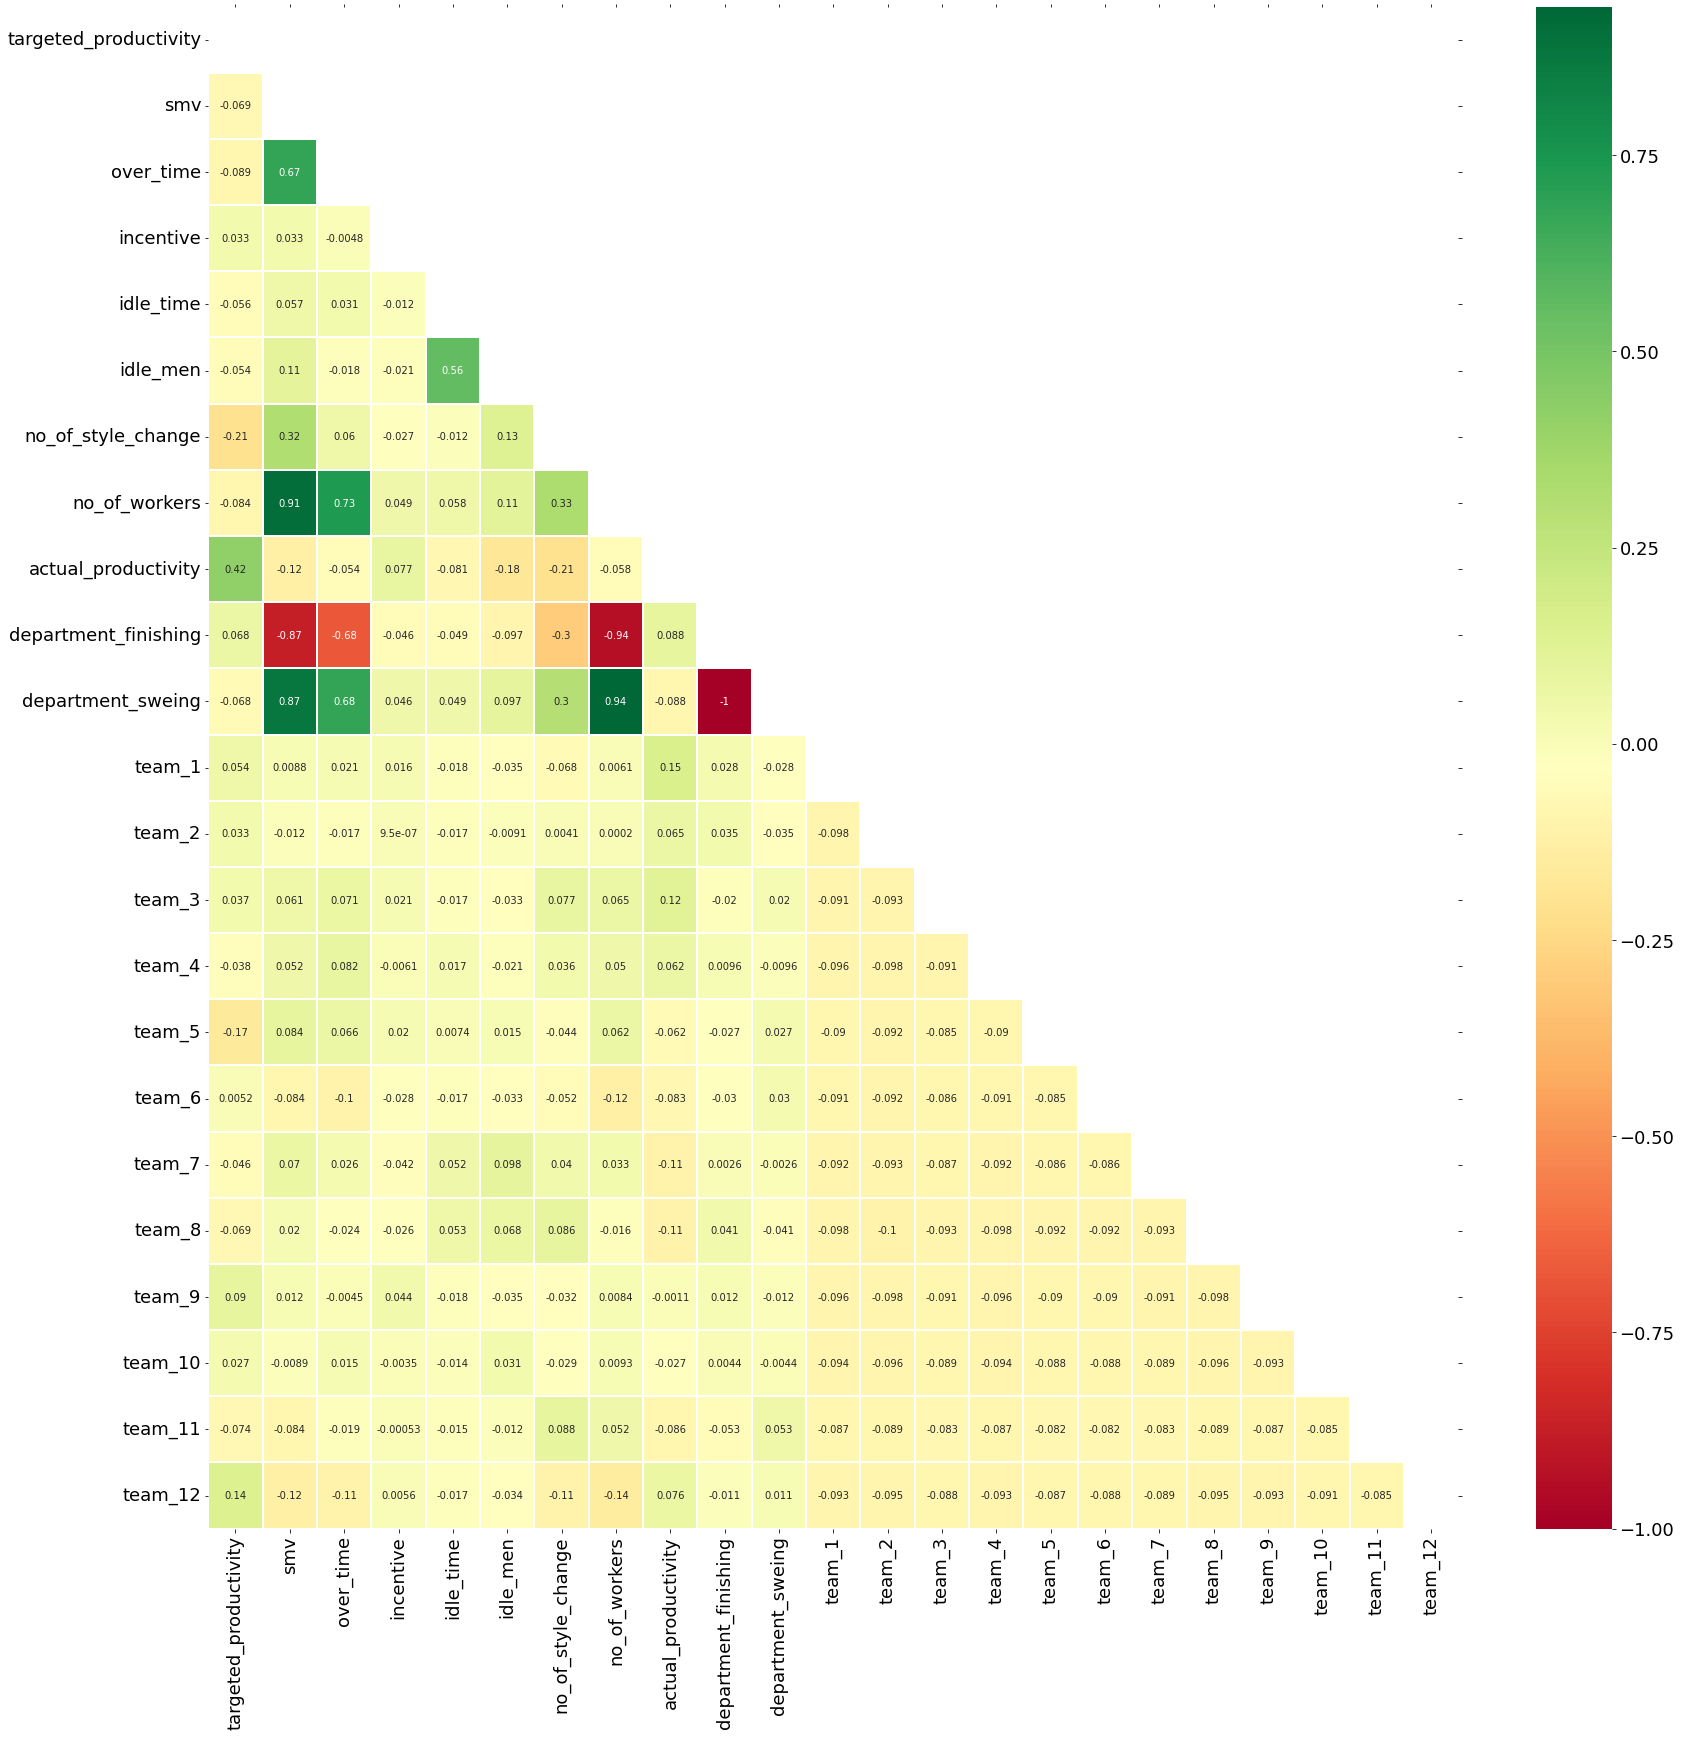

In [18]:
plt.figure(figsize=(28, 28))
matrix = np.triu(data_final.corr())
sns.heatmap(data_final.corr(), annot=True,
            linewidth=.2, mask = matrix, cmap="RdYlGn")
plt.show();

## Checking the feature importance

In [19]:
train_features = data_final.copy()
train_labels = train_features.pop('actual_productivity')

In [20]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(train_features, train_labels)

ExtraTreesRegressor()

In [21]:
print(model.feature_importances_)

[0.25616133 0.11236648 0.10794474 0.12383355 0.0048222  0.02062733
 0.02655244 0.11157827 0.0392716  0.01999103 0.02183138 0.01719304
 0.01229046 0.01246185 0.01378379 0.01487644 0.01536536 0.01682709
 0.01330718 0.01053441 0.02245914 0.0059209 ]


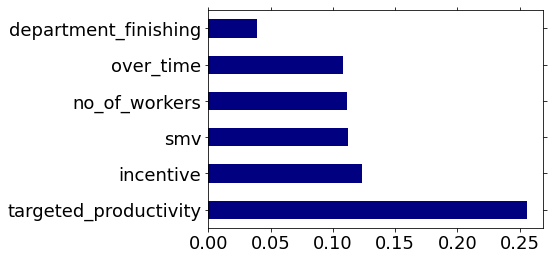

In [22]:
feature_imp = pd.Series(model.feature_importances_, index=train_features.columns)
feature_imp.nlargest(6).plot(kind='barh')
plt.show()

In [23]:
new_columns = list(feature_imp.nlargest(5).index)
print(new_columns)

['targeted_productivity', 'incentive', 'smv', 'no_of_workers', 'over_time']


In [24]:
new_columns.insert(len(new_columns)+1,'actual_productivity')
print(new_columns)

['targeted_productivity', 'incentive', 'smv', 'no_of_workers', 'over_time', 'actual_productivity']


In [25]:
reduced_df = data_final[new_columns]
reduced_df.head()

,targeted_productivity,incentive,smv,no_of_workers,over_time,actual_productivity
0,0.80,98,26.16,59.0,7080,0.940725
1,0.75,0,3.94,8.0,960,0.886500
2,0.80,50,11.41,30.5,3660,0.800570
3,0.80,50,11.41,30.5,3660,0.800570
4,0.80,50,25.90,56.0,1920,0.800382


In [116]:
#saving the dataframe
reduced_df.to_csv('clean_data.csv',index=False)